In [1]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd
from classes_synsets import SYNS

In [2]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [3]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [4]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [5]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [6]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
text_embs.shape

torch.Size([1000, 1024])

In [8]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [9]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [10]:
many_labels = []
many_embs = []
many_inds = []
med_labels = []
med_embs = []
med_inds = []
few_labels = []
few_embs = []
few_inds = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
        many_inds.append(i)
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
        med_inds.append(i)
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        few_inds.append(i)
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

many_inds = np.array(many_inds)
med_inds = np.array(med_inds)
few_inds = np.array(few_inds)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

### Trust scores

In [13]:
from sklearn.linear_model import LogisticRegression
# Train logistic regression on digits.
# model = LogisticRegression()
# model.fit(image_embeddings_train, labels_train)

model = pickle.load(open("results_sklearn/config_image_linear_probe_0/c_10/13-Nov-2022-20-07-26/final_model.sav", 'rb'))

In [14]:
# Get outputs on testing set.
y_pred = model.predict(image_embeddings)

In [15]:
import numpy as np
from sklearn.neighbors import KDTree, KNeighborsClassifier


class TrustScore:
    """
    Trust Score: a measure of classifier uncertainty based on nearest neighbors.
  """

    def __init__(self, k=10, alpha=0.0, filtering="none", min_dist=1e-12):
        """
        k and alpha are the tuning parameters for the filtering,
        filtering: method of filtering. option are "none", "density",
        "uncertainty"
        min_dist: some small number to mitigate possible division by 0.
    """
        self.k = k
        self.filtering = filtering
        self.alpha = alpha
        self.min_dist = min_dist

    def filter_by_density(self, X: np.array):
        """Filter out points with low kNN density.
    Args:
    X: an array of sample points.
    Returns:
    A subset of the array without points in the bottom alpha-fraction of
    original points of kNN density.
    """
        kdtree = KDTree(X)
        knn_radii = kdtree.query(X, k=self.k)[0][:, -1]
        eps = np.percentile(knn_radii, (1 - self.alpha) * 100)
        return X[np.where(knn_radii <= eps)[0], :]

    def filter_by_uncertainty(self, X: np.array, y: np.array):
        """Filter out points with high label disagreement amongst its kNN neighbors.
    Args:
    X: an array of sample points.
    Returns:
    A subset of the array without points in the bottom alpha-fraction of
    samples with highest disagreement amongst its k nearest neighbors.
    """
        neigh = KNeighborsClassifier(n_neighbors=self.k)
        neigh.fit(X, y)
        confidence = neigh.predict_proba(X)
        cutoff = np.percentile(confidence, self.alpha * 100)
        unfiltered_idxs = np.where(confidence >= cutoff)[0]
        return X[unfiltered_idxs, :], y[unfiltered_idxs]

    def fit(self, X: np.array, y: np.array):
        """Initialize trust score precomputations with training data.
    WARNING: assumes that the labels are 0-indexed (i.e.
    0, 1,..., n_labels-1).
    Args:
    X: an array of sample points.
    y: corresponding labels.
    """

        self.n_labels = np.max(y) + 1
        self.kdtrees = [None] * self.n_labels
        if self.filtering == "uncertainty":
            X_filtered, y_filtered = self.filter_by_uncertainty(X, y)
        for label in range(self.n_labels):
            if self.filtering == "none":
                X_to_use = X[np.where(y == label)[0]]
                self.kdtrees[label] = KDTree(X_to_use)
            elif self.filtering == "density":
                X_to_use = self.filter_by_density(X[np.where(y == label)[0]])
                self.kdtrees[label] = KDTree(X_to_use)
            elif self.filtering == "uncertainty":
                X_to_use = X_filtered[np.where(y_filtered == label)[0]]
                self.kdtrees[label] = KDTree(X_to_use)

            if len(X_to_use) == 0:
                print(
                    "Filtered too much or missing examples from a label! Please lower "
                    "alpha or check data."
                )

    def get_score(self, X: np.array, y_pred: np.array):
        """Compute the trust scores.
    Given a set of points, determines the distance to each class.
    Args:
    X: an array of sample points.
    y_pred: The predicted labels for these points.
    Returns:
    The trust score, which is ratio of distance to closest class that was not
    the predicted class to the distance to the predicted class.
    """
        d = np.tile(None, (X.shape[0], self.n_labels))
        for label_idx in range(self.n_labels):
            d[:, label_idx] = self.kdtrees[label_idx].query(X, k=2)[0][:, -1]

        sorted_d = np.sort(d, axis=1)
        d_to_pred = d[range(d.shape[0]), y_pred]
        d_to_closest_not_pred = np.where(
            sorted_d[:, 0] != d_to_pred, sorted_d[:, 0], sorted_d[:, 1]
        )
        return d_to_closest_not_pred / (d_to_pred + self.min_dist)


class KNNConfidence:
    """Baseline which uses disagreement to kNN classifier.
  """

    def __init__(self, k=10):
        self.k = k

    def fit(self, X, y):
        self.kdtree = KDTree(X)
        self.y = y

    def get_score(self, X, y_pred):
        knn_idxs = self.kdtree.query(X, k=self.k)[1]
        knn_outputs = self.y[knn_idxs]
        return np.mean(
            knn_outputs == np.transpose(np.tile(y_pred, (self.k, 1))), axis=1
        )

In [16]:
labels_train.shape

torch.Size([115846])

In [17]:
# Initialize trust score.
trust_model = TrustScore()
trust_model.fit(image_embeddings_train.numpy(), labels_train.numpy())

In [18]:
y_pred = model.predict(image_embeddings_val)
trust_score_val = trust_model.get_score(image_embeddings_val, y_pred)

In [19]:
# Compute trusts score, given (unlabeled) testing examples and (hard) model predictions.
trust_score = trust_model.get_score(image_embeddings, y_pred)

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (50000,) (20000,) 

In [ ]:
trust_score.shape

In [48]:
%store trust_score

Stored 'trust_score' (ndarray)


In [33]:
frqs_test = np.log(np.array([freqs[i] for i in labels.numpy() ]))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

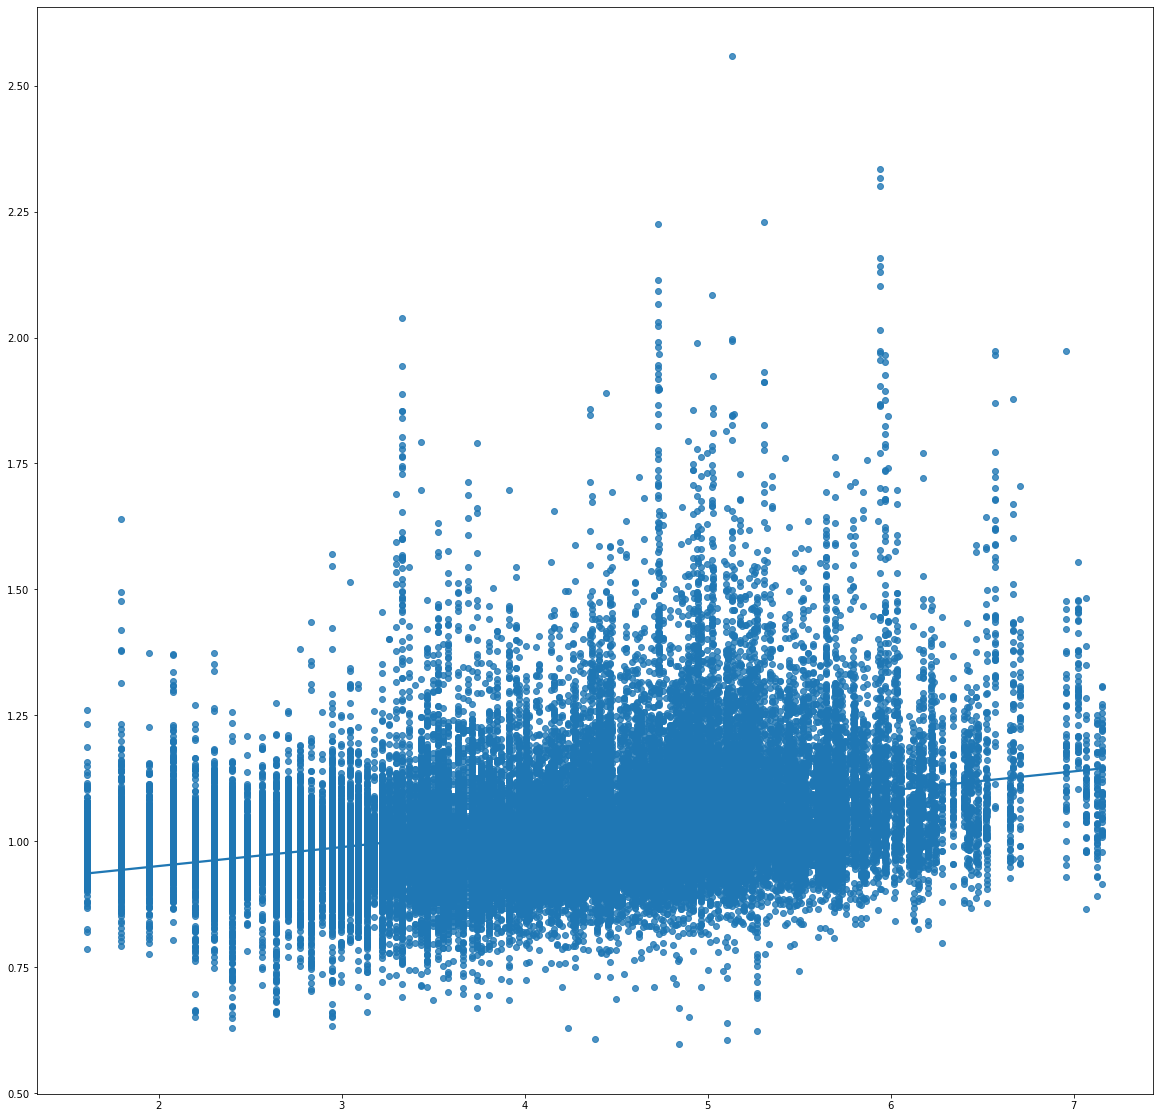

In [34]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,20)

graph = sns.regplot(x = frqs_test, y = trust_score)
sns.kdeplot(x = frqs_test, y = trust_score, fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)



In [35]:
%store -r test_indices
%store -r test_targets

In [45]:
x = np.log(trust_score[test_indices].astype('float64'))
y = test_targets[:,0].astype('float64')

/tmp/ipykernel_14439/603327700.py:2: RuntimeWarning: divide by zero encountered in log
  y = np.log(test_targets[:,0].astype('float64'))


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:>

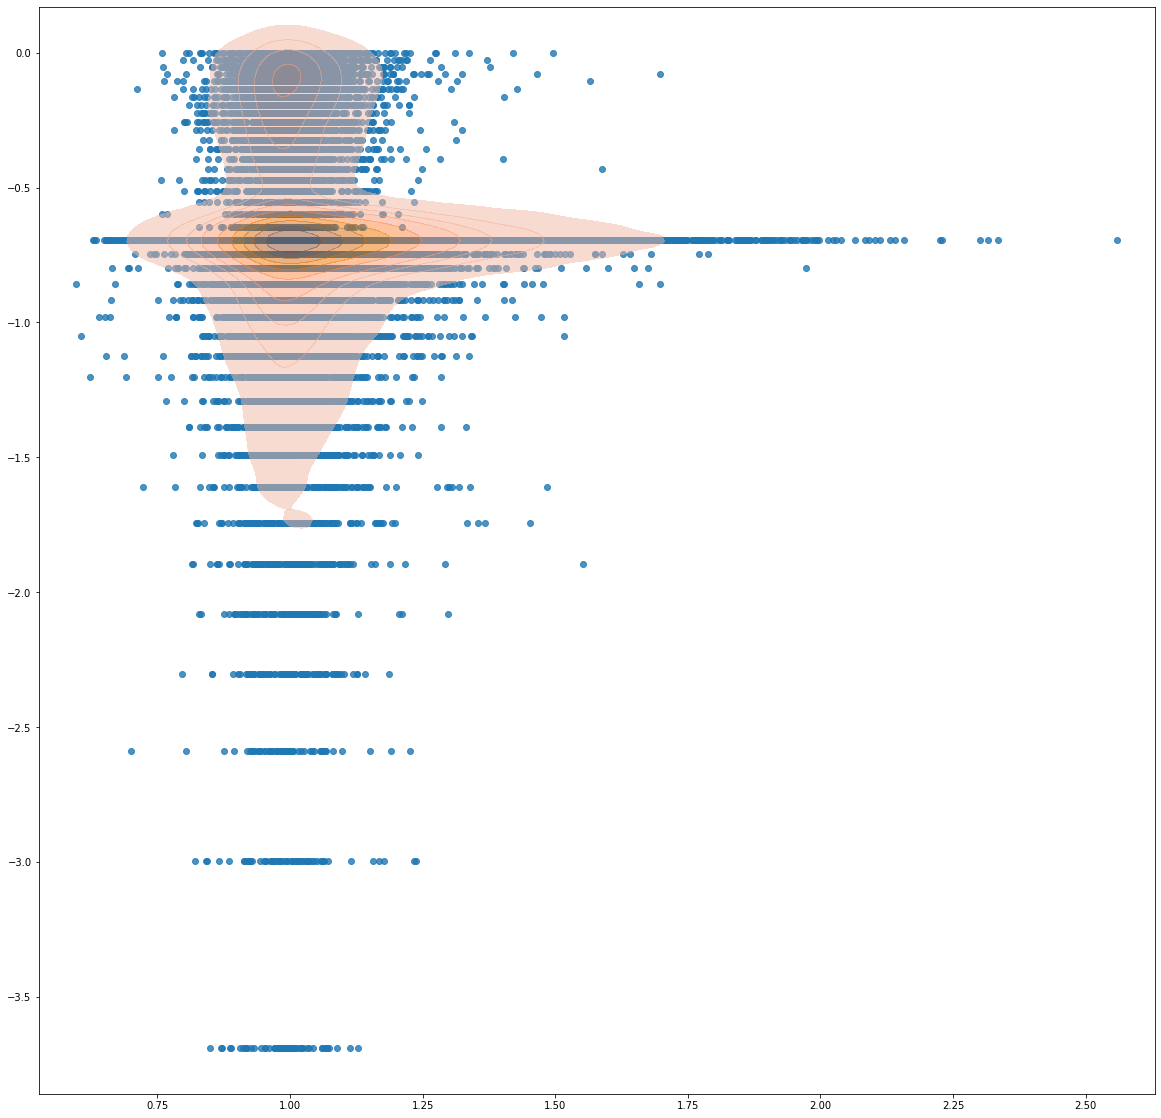

In [46]:
plt.rcParams["figure.figsize"] = (20,20)

graph = sns.regplot(x = x, y = y)
sns.kdeplot(x = x, y = y, fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)
